In [11]:
# =====================================
# 🔒 Cell 0a: Set Random Seeds for Reproducibility
# What: Ensure all models and numpy/pytorch operations are deterministic
# Why: Guarantees reproducible results for thesis/paper
# =====================================
import random
import numpy as np
import torch

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# For XGBoost, LightGBM, RandomForest (set random_state parameter individually in model init)


In [12]:
# =====================================
# 📦 Cell 0: Mount Drive & Load Dataset
# What: Access Google Drive to load Facebook dataset
# Why: Needed to read your CSV containing status, reach, and emotion features
# =====================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Facebook_data_txt.csv')
print("✅ Dataset loaded. Shape:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded. Shape: (5000, 11)


,post_id,timestamp,text,category,sentiment,language,has_link,likes,comments,shares,is_spam
0,1502,2024-11-25 10:10:00,Mental health matters. Take a break. 🎉,health_wellness,negative,hi,0,4,1,0,0
1,2587,2025-03-28 14:41:00,Having trouble logging into my Stark account—a...,customer_support,neutral,en,0,8,0,2,0
2,2654,2025-05-20 02:31:00,When you open the fridge and forget why you ca...,meme_joke,positive,en,0,74,18,4,0
3,1056,2025-01-31 16:39:00,In-depth: What market rally means for New York.,news,neutral,en,1,10,2,2,0
4,706,2024-02-25 04:12:00,Transfer rumor: J. Smith to City?,sports,positive,en,0,53,9,12,0


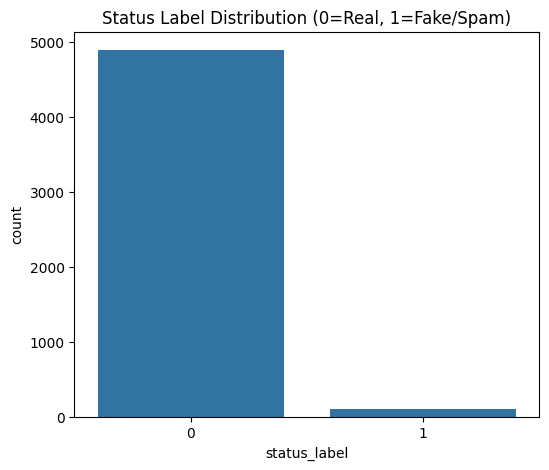

Class counts:
 status_label
0    4895
1     105
Name: count, dtype: int64


In [13]:
# =====================================
# ✍️ Cell 1: Target Label & Class Distribution
# What: Use 'is_spam' column as target 'status_label'
# Why: Avoids manual labeling and allows direct status detection
# =====================================
df['status_label'] = df['is_spam'].astype(int)

# Visualize distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.countplot(x='status_label', data=df)
plt.title("Status Label Distribution (0=Real, 1=Fake/Spam)")
plt.show()

print("Class counts:\n", df['status_label'].value_counts())


In [14]:
# =====================================
# ✍️ Cell 2: Feature Engineering
# What: Extract text, metadata, engagement, and extra features
# Why: Improve model learning with more informative signals
# =====================================
import re

def count_emojis(text):
    return len(re.findall(r'[\U00010000-\U0010ffff]', str(text)))

# Text features
df['text_length'] = df['text'].fillna('').astype(str).str.split().str.len()
df['num_emojis'] = df['text'].apply(count_emojis)
df['punctuation_count'] = df['text'].str.count(r'[!?]')

# has_links
if 'has_links' in df.columns:
    df['has_links'] = df['has_links'].astype(int)
else:
    df['has_links'] = df['text'].str.contains(r'http|www').astype(int) # detect links

# Sentiment mapping with intensity
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
df['sentiment'] = df['sentiment'].map(sentiment_mapping).fillna(0).astype(int)

# Engagement
df['total_engagement'] = df[['likes','comments','shares']].sum(axis=1)
df['log_engagement'] = np.log1p(df['total_engagement'])

# Extra features
df['avg_word_len'] = df['text'].fillna('').apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df['num_hashtags'] = df['text'].fillna('').str.count(r'#')
df['num_mentions'] = df['text'].fillna('').str.count(r'@')
df['uppercase_ratio'] = df['text'].fillna('').apply(lambda x: sum(1 for c in x if c.isupper())/len(x) if len(x)>0 else 0)

# Language one-hot encoding
if 'language' in df.columns:
    df = pd.get_dummies(df, columns=['language'], drop_first=True)

# Final style/metadata features
style_features = ['text_length','num_emojis','punctuation_count','has_links',
                  'sentiment','log_engagement','avg_word_len','num_hashtags',
                  'num_mentions','uppercase_ratio'] + [c for c in df.columns if c.startswith('language_')]

print("✅ Style/metadata features ready:", style_features)
df[style_features].head()


✅ Style/metadata features ready: ['text_length', 'num_emojis', 'punctuation_count', 'has_links', 'sentiment', 'log_engagement', 'avg_word_len', 'num_hashtags', 'num_mentions', 'uppercase_ratio', 'language_en', 'language_es', 'language_fr', 'language_hi']


,text_length,num_emojis,punctuation_count,has_links,sentiment,log_engagement,avg_word_len,num_hashtags,num_mentions,uppercase_ratio,language_en,language_es,language_fr,language_hi
0,7,1,0,0,-1,1.791759,4.571429,0,0,0.052632,False,False,False,True
1,8,0,1,0,0,2.397895,5.750000,0,0,0.037736,True,False,False,False
2,12,1,0,0,1,4.574711,4.250000,1,0,0.016129,True,False,False,False
3,8,0,0,0,0,2.708050,5.000000,0,0,0.085106,True,False,False,False
4,6,0,1,0,1,4.317488,4.666667,0,0,0.121212,True,False,False,False


In [15]:
# =====================================
# 🧠 Cell 3: Text Embeddings
# What: Convert text into numeric embeddings
# Why: Makes unstructured text usable for ML models
# =====================================
import torch
from sentence_transformers import SentenceTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

model_embed = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

text_embeddings = model_embed.encode(
    df['text'].fillna('').astype(str).tolist(),
    batch_size=128,
    show_progress_bar=True,
    device=device,
    convert_to_numpy=True
)

print("✅ Text embeddings shape:", text_embeddings.shape)


Using device: cpu


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

✅ Text embeddings shape: (5000, 384)


In [16]:
# =====================================
# ✍️ Cell 4 (Updated): Combine Features & Proper Split
# What: Merge text embeddings + style features, create train/val/test
# Why: Ensure unbiased evaluation and separate test set for final reporting
# =====================================

from sklearn.model_selection import train_test_split

# Combine all features (text embeddings + style features)
X_full = np.hstack([text_embeddings, df[style_features].values])
y = df['status_label'].values

# 70/15/15 split
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# Also create text-only variant (to evaluate engagement leakage)
X_text_only = text_embeddings
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text_only, y, test_size=0.15, random_state=42, stratify=y
)
print("✅ Created both full-feature and text-only versions.")


Train: 3502 | Val: 748 | Test: 750
✅ Created both full-feature and text-only versions.


In [17]:
# =====================================
# 🔧 Cell 5 (Updated): Handle Class Imbalance with Class Weights
# What: Compute class weights dynamically instead of using SMOTE
# Why: SMOTE distorts semantic embeddings; class weights preserve structure
# =====================================

from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

print("✅ Computed class weights:", class_weight_dict)



✅ Computed class weights: {np.int64(0): np.float64(0.510644502770487), np.int64(1): np.float64(23.986301369863014)}


In [18]:
# =====================================
# 🧠 Cell 6 (Updated): Train XGBoost, Random Forest, and LightGBM (with weights)
# What: Train weighted models for balanced learning
# Why: Prevents bias toward majority class without using SMOTE
# =====================================

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

num_pos = sum(y_train==1)
num_neg = sum(y_train==0)
scale_pos_weight = num_neg / num_pos

xgb_model = XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss'
)

rf_model = RandomForestClassifier(
    n_estimators=200, random_state=42,
    class_weight=class_weight_dict
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.05,
    class_weight='balanced', random_state=42
)

# Train on full feature set
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

print("✅ Models trained on full feature set")

# Train text-only baseline for comparison
xgb_text = XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss'
)
xgb_text.fit(X_train_text, y_train_text)
print("✅ Text-only baseline trained (no engagement features)")


[LightGBM] [Info] Number of positive: 73, number of negative: 3429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98120
[LightGBM] [Info] Number of data points in the train set: 3502, number of used features: 396
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [19]:
# =====================================
# 🔍 Cell 7 (Updated): Ensemble + Threshold Optimization
# What: Optimize ensemble threshold on validation, evaluate on test
# Why: Ensure unbiased metrics, report macro-F1 and ROC-AUC
# =====================================

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

# Weighted ensemble predictions (validation)
def ensemble_predict_prob(models, X, weights=[0.5, 0.3, 0.2]):
    xgb, rf, lgbm = models
    return (xgb.predict_proba(X)[:,1]*weights[0] +
            rf.predict_proba(X)[:,1]*weights[1] +
            lgbm.predict_proba(X)[:,1]*weights[2])

thresholds = np.arange(0.2, 0.5, 0.05)
results = []

for t in thresholds:
    prob_val = ensemble_predict_prob([xgb_model, rf_model, lgb_model], X_val)
    pred_val = (prob_val >= t).astype(int)
    f1 = f1_score(y_val, pred_val)
    prec = precision_score(y_val, pred_val)
    rec = recall_score(y_val, pred_val)
    macro = f1_score(y_val, pred_val, average='macro')
    auc = roc_auc_score(y_val, prob_val)
    results.append({'Threshold': t, 'Accuracy': accuracy_score(y_val, pred_val),
                    'F1_fake': f1, 'Precision_fake': prec, 'Recall_fake': rec,
                    'Macro_F1': macro, 'ROC_AUC': auc})

df_val = pd.DataFrame(results)
display(df_val)

best_thresh = df_val.sort_values('F1_fake', ascending=False).iloc[0]['Threshold']
print(f"🎯 Best Validation Threshold: {best_thresh}")

# Final test evaluation
prob_test = ensemble_predict_prob([xgb_model, rf_model, lgb_model], X_test)
pred_test = (prob_test >= best_thresh).astype(int)

acc = accuracy_score(y_test, pred_test)
f1f = f1_score(y_test, pred_test)
macro_f1 = f1_score(y_test, pred_test, average='macro')
auc = roc_auc_score(y_test, prob_test)

print(f"\n=== Test Results ===\nAccuracy={acc:.3f}, F1_fake={f1f:.3f}, Macro-F1={macro_f1:.3f}, ROC-AUC={auc:.3f}")


X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names


,Threshold,Accuracy,F1_fake,Precision_fake,Recall_fake,Macro_F1,ROC_AUC
0,0.20,0.961230,0.171429,0.157895,0.1875,0.575790,0.945782
1,0.25,0.965241,0.187500,0.187500,0.1875,0.584870,0.945782
2,0.30,0.965241,0.133333,0.142857,0.1250,0.557799,0.945782
3,0.35,0.965241,0.133333,0.142857,0.1250,0.557799,0.945782
4,0.40,0.965241,0.133333,0.142857,0.1250,0.557799,0.945782
5,0.45,0.966578,0.137931,0.153846,0.1250,0.560445,0.945782


🎯 Best Validation Threshold: 0.25

=== Test Results ===
Accuracy=0.968, F1_fake=0.200, Macro-F1=0.592, ROC-AUC=0.946


X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [20]:
# =====================================
# 💾 Cell 9 (Final Updated): Save All Artifacts for Inference
# What: Persist models, feature lists, threshold, and random seed
# Why: Enables reproducibility, consistent inference, and publication-ready reproducibility
# =====================================

import joblib, json, os

os.makedirs("artifacts", exist_ok=True)

# Save trained models
joblib.dump(xgb_model, "artifacts/status_xgb.joblib")
joblib.dump(rf_model, "artifacts/status_rf.joblib")
joblib.dump(lgb_model, "artifacts/status_lgb.joblib")

# Save style/metadata features and text features separately
joblib.dump(style_features, "artifacts/status_style_features.joblib")
joblib.dump(['text_embeddings'], "artifacts/status_text_features.joblib")  # just for reference

# Save threshold and random seed for reproducibility
meta = {
    "best_threshold": float(best_thresh),
    "random_seed": RANDOM_SEED
}
json.dump(meta, open("artifacts/status_meta.json", "w"))

print("✅ Models, features, threshold, and seed saved to /artifacts")



✅ Models, features, threshold, and seed saved to /artifacts


In [21]:
# =====================================
# 📈 Cell 10: Statistical Confidence for F1 (Bootstrap)
# What: Estimate 95% CI for F1_fake on test set
# Why: Report robust metrics in paper instead of single-point estimates
# =====================================

from sklearn.utils import resample

f1_scores = []
for _ in range(500):
    idx = resample(np.arange(len(y_test)), replace=True)
    f1_scores.append(f1_score(y_test[idx], pred_test[idx]))

ci_low, ci_high = np.percentile(f1_scores, [2.5, 97.5])
print(f"95% Confidence Interval for F1_fake: [{ci_low:.3f}, {ci_high:.3f}]")


95% Confidence Interval for F1_fake: [0.000, 0.385]


In [24]:
# =====================================
# 🚨 Cell 13 (Fixed): Flag Suspicious Posts (Final)
# =====================================

final_threshold = 0.4

# ✅ Use full-feature matrices already created
X_all = np.vstack([X_train, X_val, X_test])  # combine train/val/test
# If you want to keep original df order, you can just use X_full

# ✅ Compute ensemble suspicion score if not already present
if 'suspicion_score' not in df.columns:
    prob_ensemble = (
        xgb_model.predict_proba(X_full)[:, 1] * 0.5 +
        rf_model.predict_proba(X_full)[:, 1] * 0.3 +
        lgb_model.predict_proba(X_full)[:, 1] * 0.2
    )
    df['suspicion_score'] = prob_ensemble
    print("✅ Recomputed ensemble suspicion_score")

# ✅ Predict labels using threshold
df['predicted_label'] = (df['suspicion_score'] >= final_threshold).astype(int)

# ✅ Filter flagged posts
df_flagged = df[df['predicted_label'] == 1]
print(f"🚨 Total flagged posts as fake/spam: {len(df_flagged)}")

# ✅ Show top 10 flagged posts
df_flagged[['text', 'suspicion_score']].head(10)


X does not have valid feature names, but LGBMClassifier was fitted with feature names


✅ Recomputed ensemble suspicion_score
🚨 Total flagged posts as fake/spam: 102


,text,suspicion_score
143,New drop: smartwatch! Grab yours today.,0.873157
151,Use code FREESHIP for free shipping on laptop.,0.878270
212,New drop: headphones! Grab yours today.,0.879203
235,Buy 1 get 1 on all headphones until Saturday.,0.891146
253,FLASH SALE: sneakers at 30% off. Limited time!...,0.757162
263,New drop: smartwatch! Grab yours today.,0.882921
270,Use code WELCOME10 for free shipping on smartw...,0.888707
359,New drop: smartwatch! Grab yours today.,0.441369
452,Buy 1 get 1 on all laptop until Thursday.,0.920334
455,New drop: coffee maker! Grab yours today.,0.962628


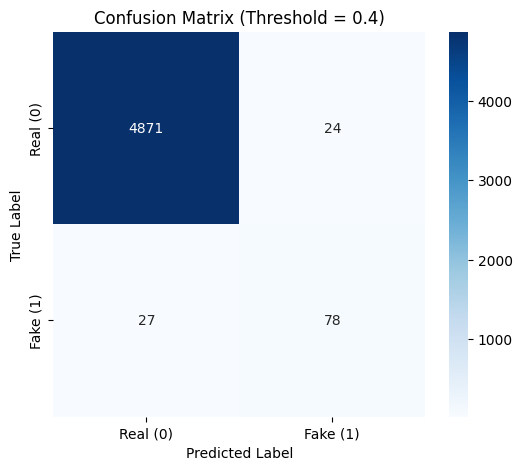

In [25]:
# =====================================
# 📊 Cell 14: Confusion Matrix
# What: Visualize performance of final ensemble at threshold 0.4
# Why: Easy to interpret rare-class detection performance for thesis/paper
# =====================================
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = df['status_label']
y_pred = df['predicted_label']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real (0)','Fake (1)'],
            yticklabels=['Real (0)','Fake (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Threshold = {final_threshold})')
plt.show()


In [26]:
# =====================================
# 📈 Cell 15: Evaluation Table for Multiple Thresholds
# What: Compute Accuracy, F1, Precision, Recall at different thresholds
# Why: Show threshold tradeoff for optimal F1_fake; publishable table
# =====================================
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4]
eval_results = []

for t in thresholds:
    y_pred_t = (df['suspicion_score'] >= t).astype(int)
    eval_results.append({
        'Threshold': t,
        'Accuracy': round(accuracy_score(y_true, y_pred_t),3),
        'F1_fake': round(f1_score(y_true, y_pred_t),3),
        'Precision_fake': round(precision_score(y_true, y_pred_t),3),
        'Recall_fake': round(recall_score(y_true, y_pred_t),3)
    })

df_eval = pd.DataFrame(eval_results)
display(df_eval)

best_thresh = df_eval.sort_values('F1_fake', ascending=False).iloc[0]['Threshold']
print(f"🎯 Best threshold (highest F1_fake) = {best_thresh}")


,Threshold,Accuracy,F1_fake,Precision_fake,Recall_fake
0,0.20,0.988,0.718,0.687,0.752
1,0.25,0.989,0.742,0.731,0.752
2,0.30,0.990,0.754,0.765,0.743
3,0.35,0.990,0.754,0.765,0.743
4,0.40,0.990,0.754,0.765,0.743


🎯 Best threshold (highest F1_fake) = 0.3


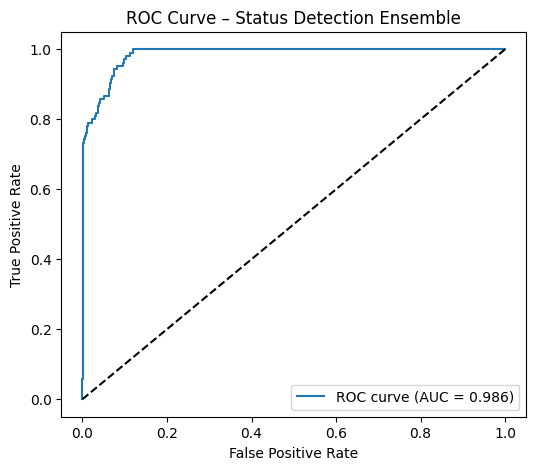

In [27]:
# =====================================
# 📈 ROC Curve Visualization (Status Detection)
# What: Visualize trade-off between True Positive and False Positive Rates
# Why: Complements AUC metric for publication-quality presentation
# =====================================
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, df['suspicion_score'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Status Detection Ensemble")
plt.legend(loc="lower right")
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



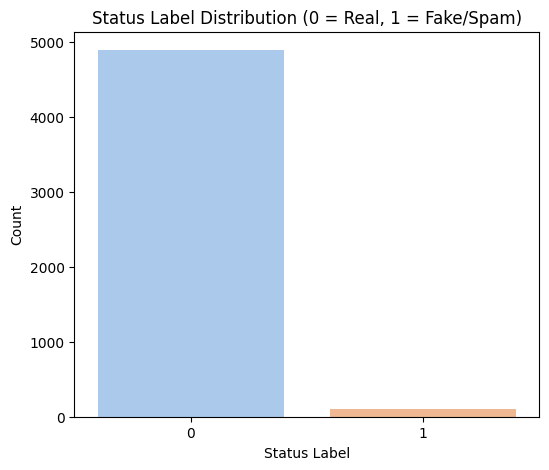

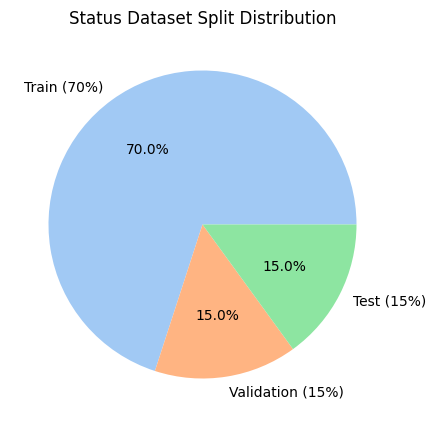

In [28]:
# ================================
# 🧠 Status Detection: Distribution & Split Visualization
# ================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# ---- Bar Plot (Status Distribution)
plt.figure(figsize=(6,5))
sns.countplot(x='status_label', data=df, palette="pastel")
plt.title("Status Label Distribution (0 = Real, 1 = Fake/Spam)")
plt.xlabel("Status Label")
plt.ylabel("Count")
plt.show()

# ---- Pie Chart (Train/Val/Test Split)
# Assuming your split was 70-15-15
split_sizes = [70, 15, 15]
split_labels = ['Train (70%)', 'Validation (15%)', 'Test (15%)']

plt.figure(figsize=(5,5))
plt.pie(split_sizes, labels=split_labels, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Status Dataset Split Distribution")
plt.show()
